In [1]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [2]:

from tqdm import tqdm 
import os 
import keras
import numpy as np 
import tensorflow as tf


# Data 
import scipy.ndimage as mp
from glob import glob
import pathlib
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi

# Model prepare
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt

#from rembg import remove
from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence


In [5]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as smp;


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [7]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

## Data preprocessing

In [8]:

def del_mask_img(images, masks):
    for im, ma in tqdm(zip(images, masks), total = len(images)):
        #sleep(0.00001)
        mask = load_img(ma) 
        mask= img_to_array(mask)[:,:,0] #np
        mask = np.where(mask > 250, 1, 0) # 68-0 253-1 artefact after saving np.array to mask
        m_sum = np.sum(mask) 
        mask_to_img_relation = m_sum/(mask.shape[0]*mask.shape[1])
        if mask_to_img_relation >= 0.75 or mask_to_img_relation <= 0.35:
            masks.remove(ma)
            images.remove(im)
    return images, masks

In [9]:
# создание ссылок на изображения и маски
img = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
mask = sorted(glob(r'../input/mask-aisegmentcom-matting-human-datasets/masks/*/*/*')) # corected masks
first_len = len(img)

In [10]:
img, mask = del_mask_img(img, mask)
print(f"Dataset size - {first_len}"
f"\nDatasate size after removal outliers - {len(img)}"
f"\nDaraset reduction - {np.round(100.00 - len(img)*100/first_len,2)}%")

 93%|█████████▎| 31886/34426 [06:44<00:32, 78.89it/s]

Dataset size - 34426
Datasate size after removal outliers - 31885
Daraset reduction - 7.38%


## Visualisation

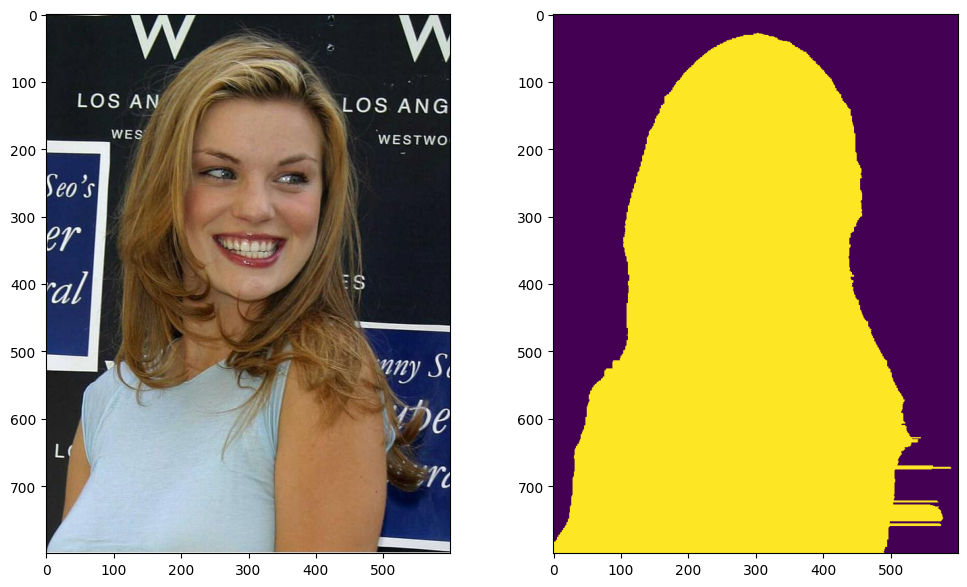

In [11]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
im = plt.imread(img[99])
plt.imshow(im)
plt.subplot(1,2,2)
m = plt.imread(mask[99])
plt.imshow(m)
plt.show()

## Data Loader 
for optimal use of RAM since all the images will not fit into RAM


In [38]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        
        #super().__init__(workers, use_multiprocessing, max_queue_size)  #**kwargs)
        
        self.use_multiprocessing = use_multiprocessing
        self.workers = workers
        self.max_queue_size = max_queue_size
        
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()  #np.empty((self.batch_size, self.dim[0], self.dim[1],  self.dim[1])) #np.array([])#list()
        batch_labels = list()#np.empty((self.batch_size, self.dim[0], self.dim[1])) # np.array([]) #list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            #Store class
            label = load_img(self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label >= 250
            #label = label == 253
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

## Visualisation Learning

In [23]:
def ShowImage(image, title=None, cmap=None):
    #возвращает изображение из входа матрицы
    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')
    
class ShowProgress(Callback):
    def __init__(self, valid):
        self.valid = valid
        
    
    def on_epoch_end(self, epoch, logs):
        #ax = plt.axes()
        #ax.set_facecolor("gray")
        
        plt.figure(figsize=(15,8))
        #i = np.random.randint(valid.batch_size-1)
        
        img = valid[0][0][0:3] # так как метод предикт принимает только от 2х и более картинок
        pred_mask = self.model.predict(img)[0] #[i-1]
        
        pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
        mapping = cv.bitwise_and(img[0],img[0],mask=pred_mask)#[0]  i-2 i-2

        plt.subplot(1,4,1)
        ShowImage(img[0],title="True IMG")
    
        plt.subplot(1,4,2)
        ShowImage(pred_mask, title="Predicted Mask")
    
        plt.subplot(1,4,3)
        ShowImage(valid[0][1][0].reshape(224, 224), title="True Mask") #1!!!
    
        plt.subplot(1,4,4)
        ShowImage(mapping, title="Mapping Mask")
    
        plt.tight_layout()
        plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(img, mask, test_size=0.30, random_state=44)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=44)

In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [26]:
generator = DataGenerator(X_train, y_train, batch_size=32, dim=(224,224,3),shuffle=True, )
valid = DataGenerator(X_test ,y_test, batch_size=32, dim=(224,224,3))

## Learning

In [27]:
callback = [EarlyStopping(
    monitor='IoU', #
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10
), ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, min_lr=1.e-08), 
            ShowProgress(valid)]


In [28]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet')

Epoch 1/40


I0000 00:00:1734782177.365073     111 service.cc:145] XLA service 0x7c96c0004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734782177.365139     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734782177.365146     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734782288.257193     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step/step - IoU: 0.4409 - accuracy: 0.9419 - loss: 0.52


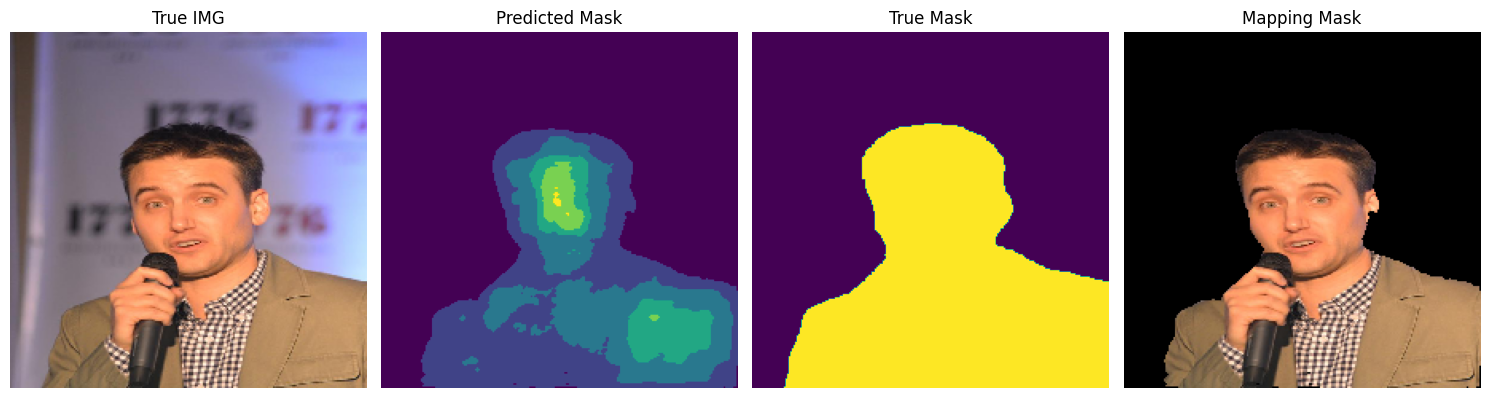

697/697 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - IoU: 0.4408 - accuracy: 0.9419 - loss: 0.5199 - val_IoU: 0.6603 - val_accuracy: 0.9820 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step/step - IoU: 0.5910 - accuracy: 0.9757 - loss: 0.088


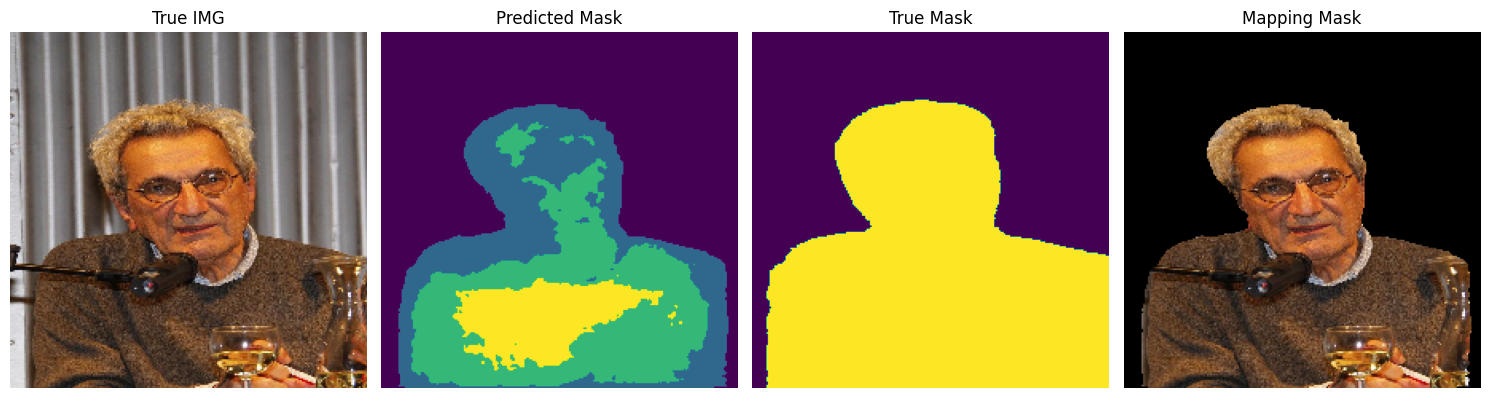

697/697 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - IoU: 0.5908 - accuracy: 0.9757 - loss: 0.0885 - val_IoU: 0.6303 - val_accuracy: 0.9794 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step/step - IoU: 0.6495 - accuracy: 0.9811 - loss: 0.064


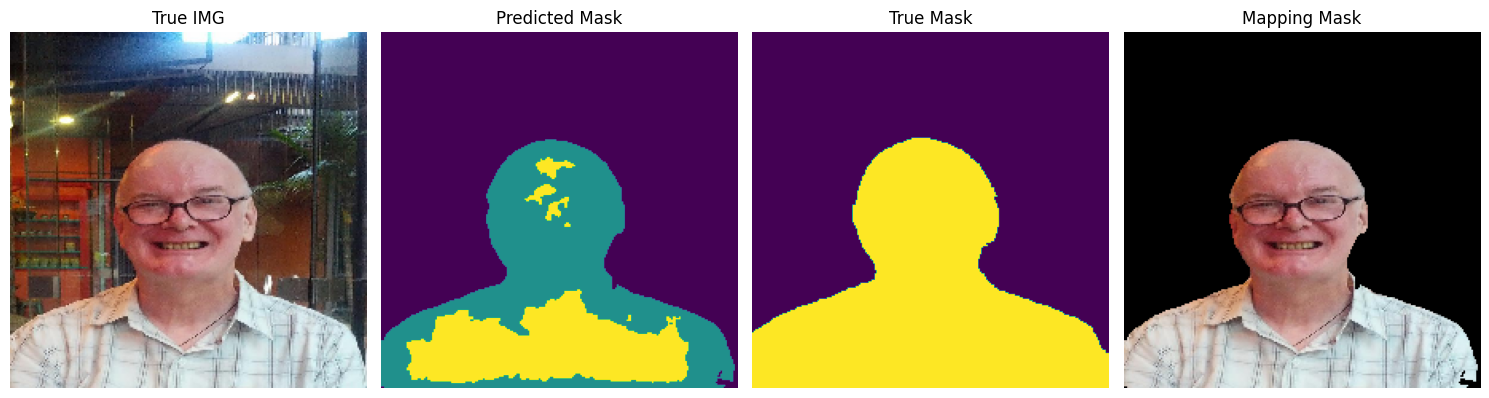

697/697 ━━━━━━━━━━━━━━━━━━━━ 731s 1s/step - IoU: 0.6493 - accuracy: 0.9811 - loss: 0.0646 - val_IoU: 0.6997 - val_accuracy: 0.9850 - val_loss: 0.0506 - learning_rate: 3.0000e-04
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.6808 - accuracy: 0.9839 - loss: 0.053


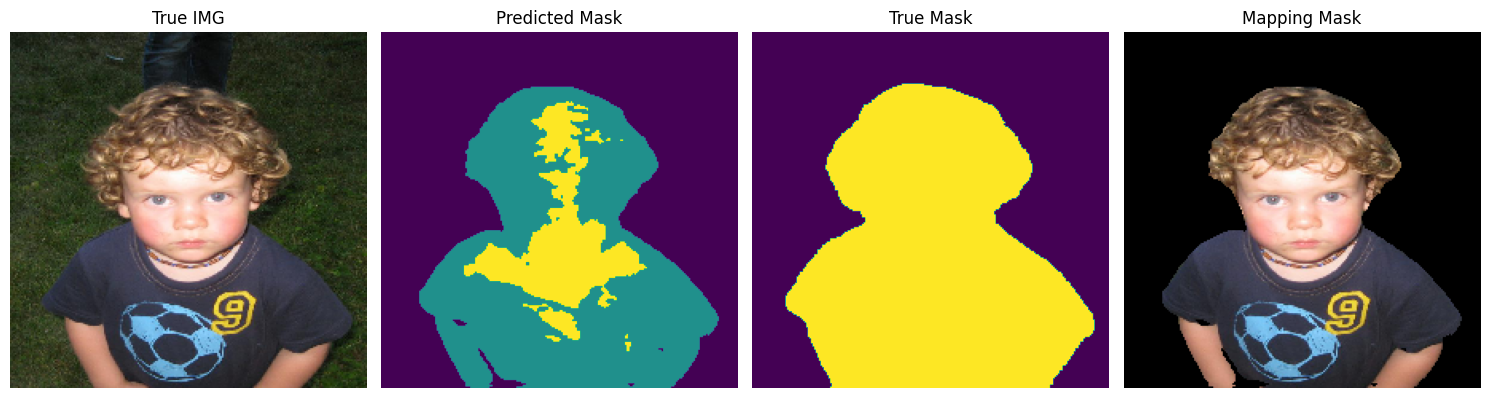

697/697 ━━━━━━━━━━━━━━━━━━━━ 729s 1s/step - IoU: 0.6806 - accuracy: 0.9839 - loss: 0.0536 - val_IoU: 0.7007 - val_accuracy: 0.9850 - val_loss: 0.0502 - learning_rate: 3.0000e-04
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.6969 - accuracy: 0.9852 - loss: 0.046


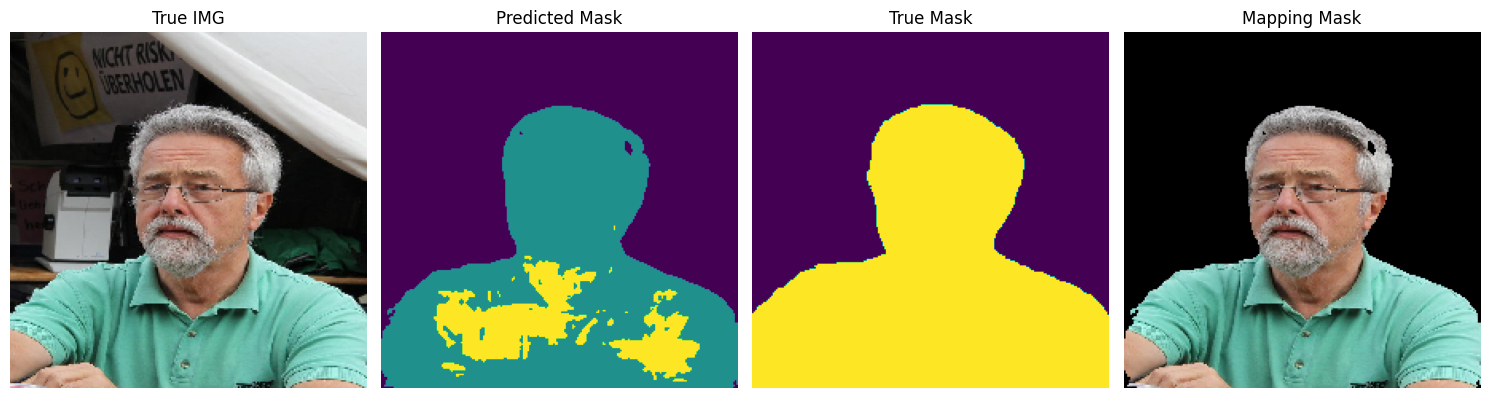

697/697 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - IoU: 0.6966 - accuracy: 0.9852 - loss: 0.0463 - val_IoU: 0.7163 - val_accuracy: 0.9861 - val_loss: 0.0457 - learning_rate: 3.0000e-04
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step/step - IoU: 0.7074 - accuracy: 0.9861 - loss: 0.044


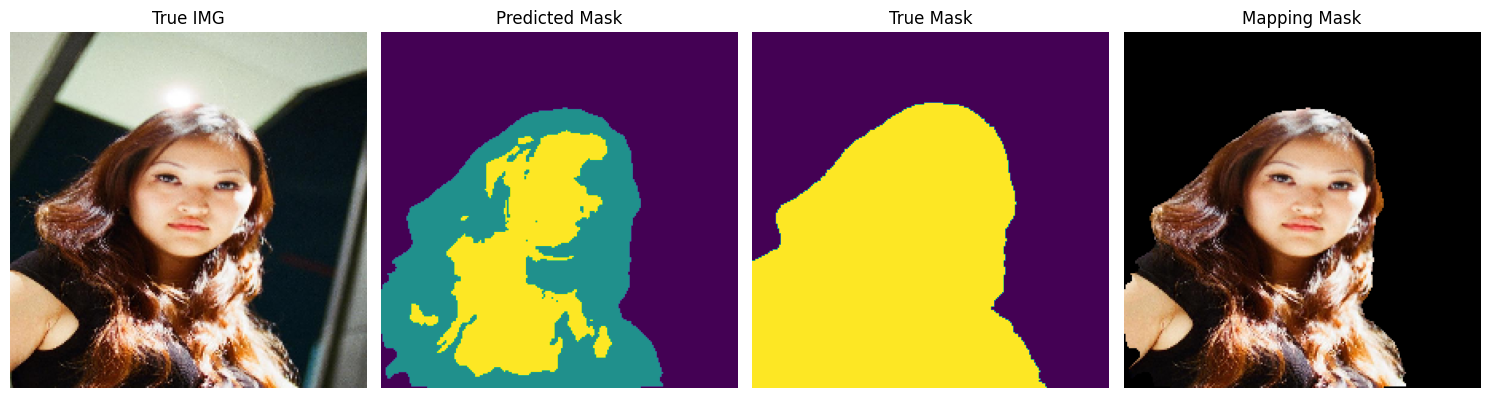

697/697 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - IoU: 0.7071 - accuracy: 0.9861 - loss: 0.0442 - val_IoU: 0.6752 - val_accuracy: 0.9831 - val_loss: 0.0561 - learning_rate: 3.0000e-04
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.6888 - accuracy: 0.9848 - loss: 0.045


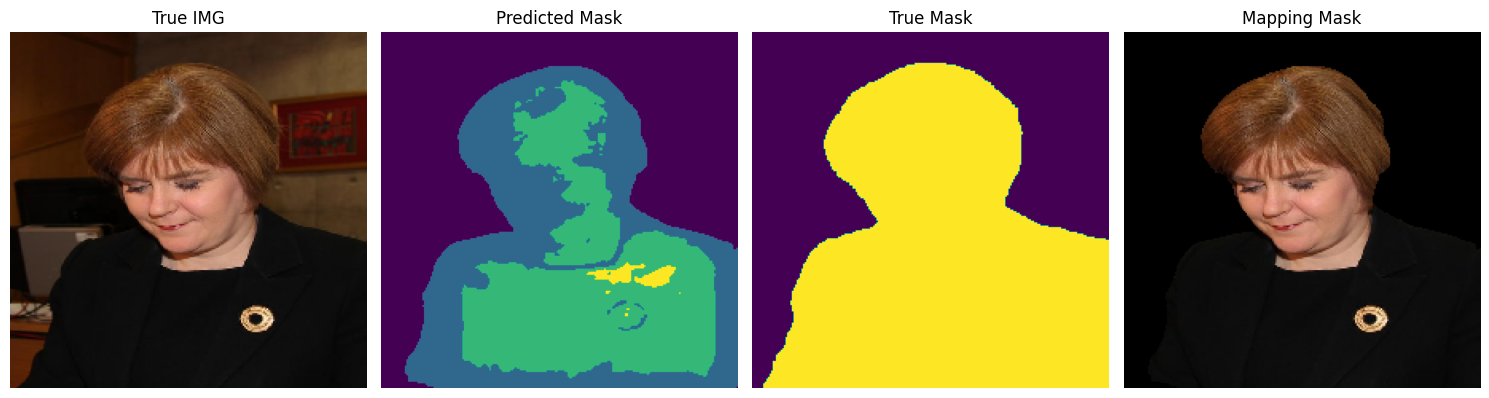

697/697 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - IoU: 0.6885 - accuracy: 0.9848 - loss: 0.0453 - val_IoU: 0.7270 - val_accuracy: 0.9868 - val_loss: 0.0457 - learning_rate: 9.0000e-05
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.7200 - accuracy: 0.9870 - loss: 0.039


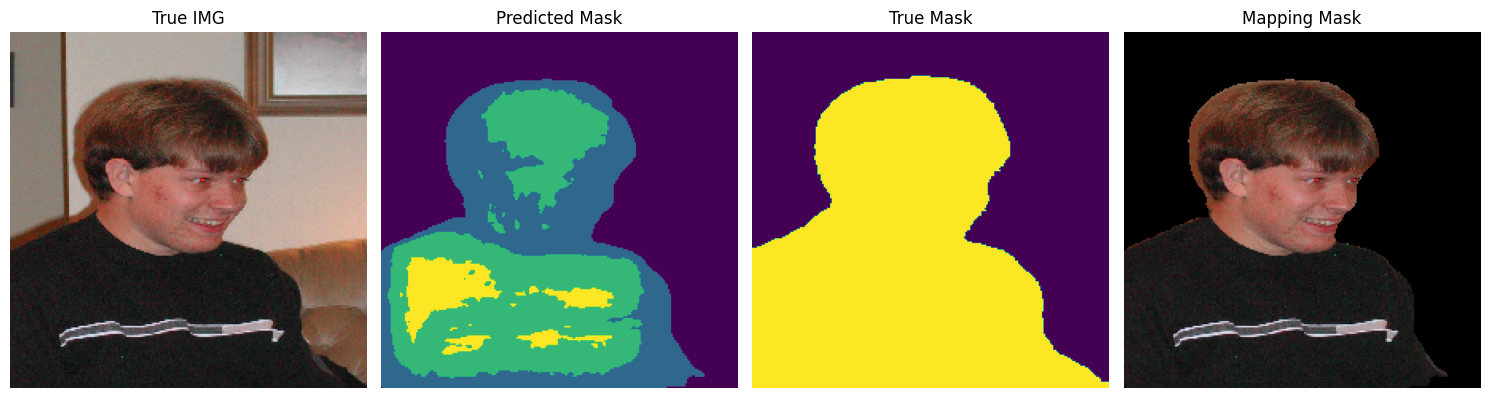

697/697 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - IoU: 0.7198 - accuracy: 0.9870 - loss: 0.0391 - val_IoU: 0.7311 - val_accuracy: 0.9871 - val_loss: 0.0445 - learning_rate: 2.7000e-05
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7226 - accuracy: 0.9873 - loss: 0.038


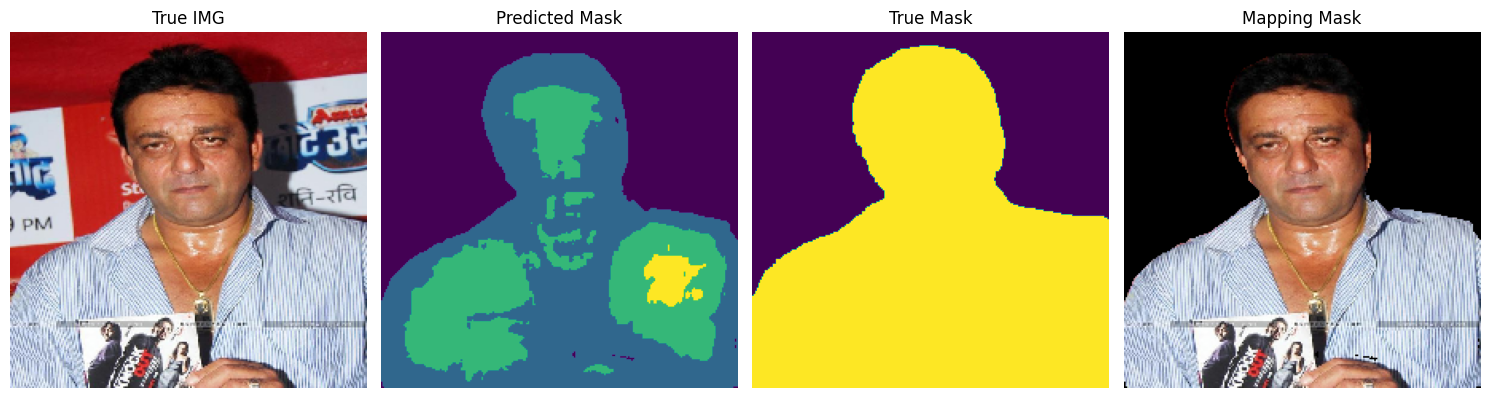

697/697 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - IoU: 0.7223 - accuracy: 0.9873 - loss: 0.0381 - val_IoU: 0.7360 - val_accuracy: 0.9874 - val_loss: 0.0438 - learning_rate: 2.7000e-05
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step/step - IoU: 0.7243 - accuracy: 0.9874 - loss: 0.037


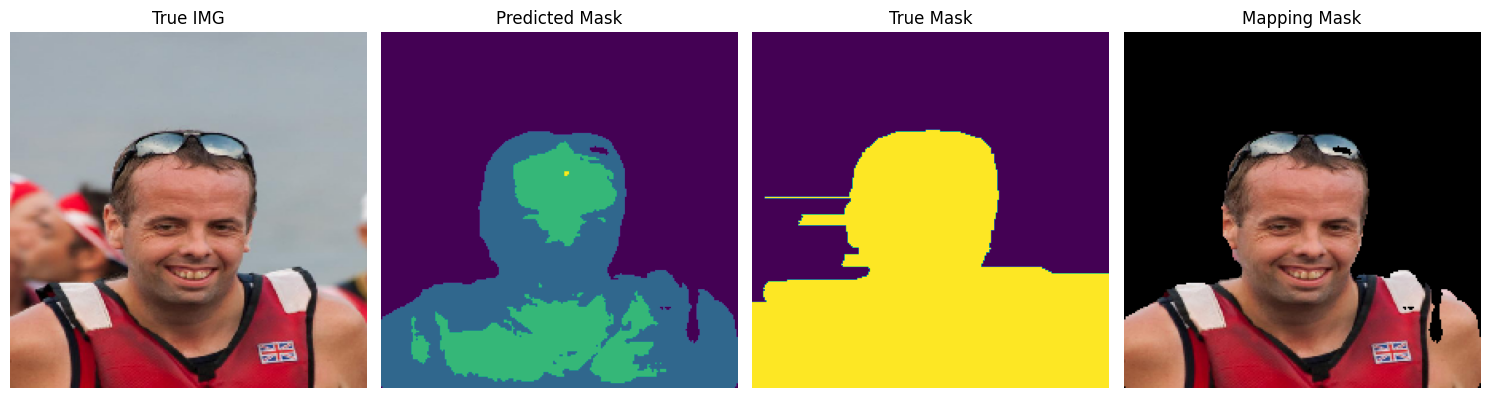

697/697 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - IoU: 0.7241 - accuracy: 0.9874 - loss: 0.0378 - val_IoU: 0.7375 - val_accuracy: 0.9875 - val_loss: 0.0432 - learning_rate: 2.7000e-05
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.7281 - accuracy: 0.9876 - loss: 0.036


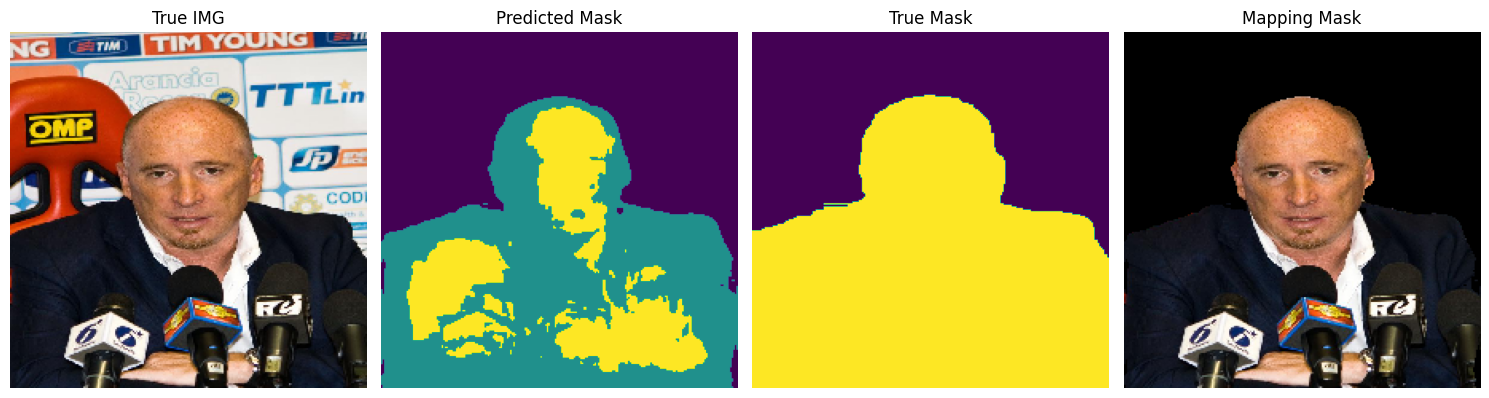

697/697 ━━━━━━━━━━━━━━━━━━━━ 745s 1s/step - IoU: 0.7278 - accuracy: 0.9876 - loss: 0.0362 - val_IoU: 0.7405 - val_accuracy: 0.9877 - val_loss: 0.0430 - learning_rate: 2.7000e-05
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.7354 - accuracy: 0.9881 - loss: 0.034


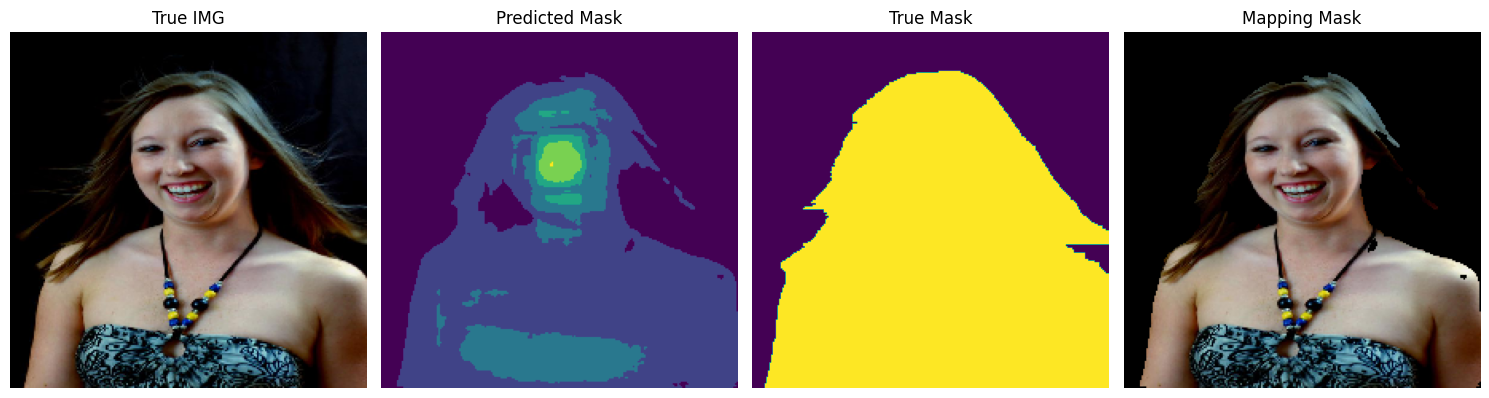

697/697 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - IoU: 0.7352 - accuracy: 0.9881 - loss: 0.0347 - val_IoU: 0.7352 - val_accuracy: 0.9874 - val_loss: 0.0437 - learning_rate: 2.7000e-05
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7345 - accuracy: 0.9880 - loss: 0.034


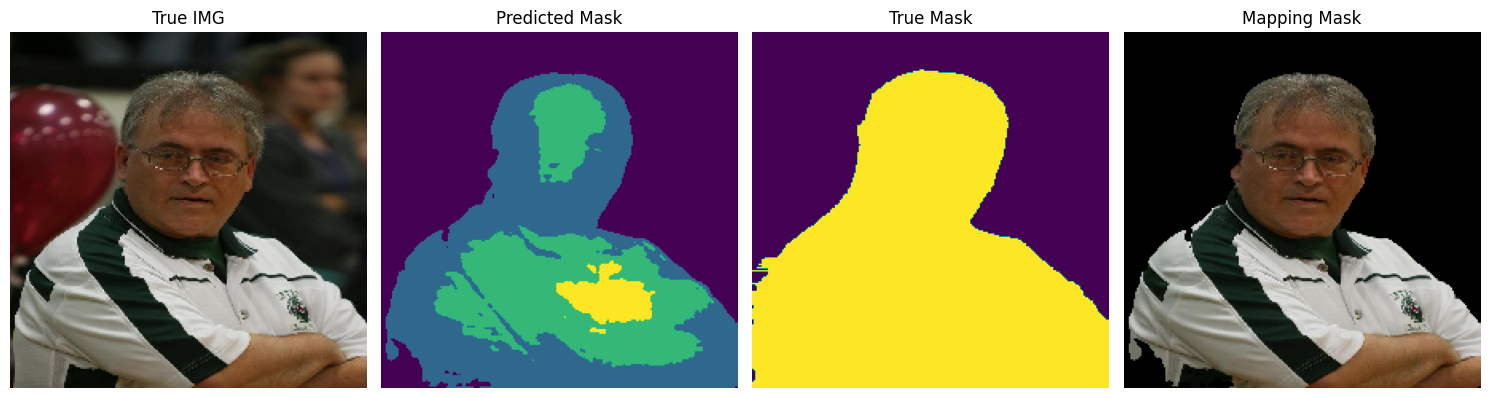

697/697 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - IoU: 0.7342 - accuracy: 0.9880 - loss: 0.0342 - val_IoU: 0.7432 - val_accuracy: 0.9879 - val_loss: 0.0424 - learning_rate: 8.1000e-06
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7390 - accuracy: 0.9884 - loss: 0.033


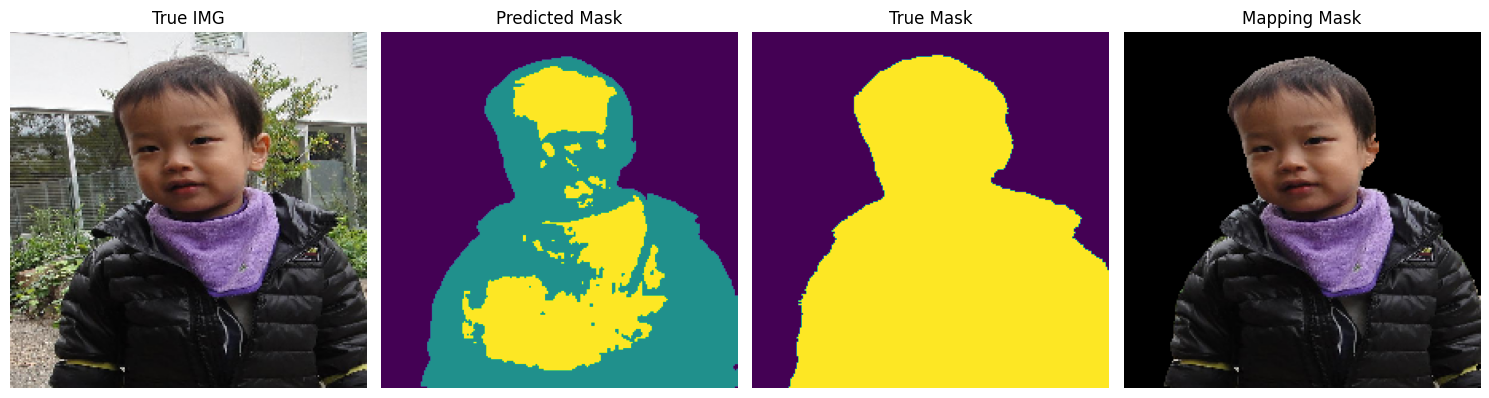

697/697 ━━━━━━━━━━━━━━━━━━━━ 714s 1s/step - IoU: 0.7387 - accuracy: 0.9884 - loss: 0.0337 - val_IoU: 0.7455 - val_accuracy: 0.9880 - val_loss: 0.0431 - learning_rate: 8.1000e-06
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7413 - accuracy: 0.9884 - loss: 0.033


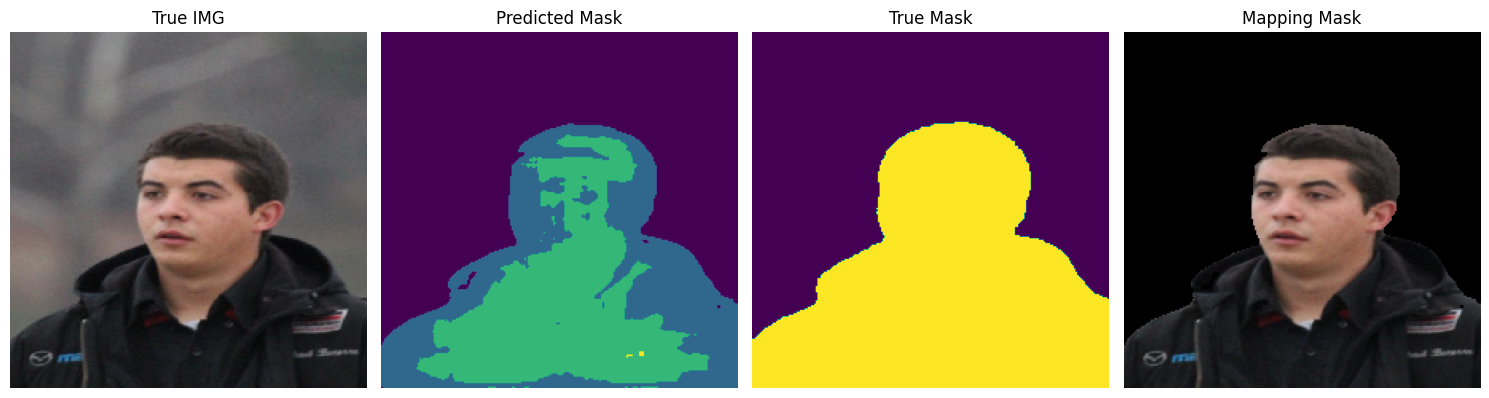

697/697 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - IoU: 0.7411 - accuracy: 0.9884 - loss: 0.0335 - val_IoU: 0.7447 - val_accuracy: 0.9880 - val_loss: 0.0430 - learning_rate: 2.4300e-06
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.7360 - accuracy: 0.9880 - loss: 0.033


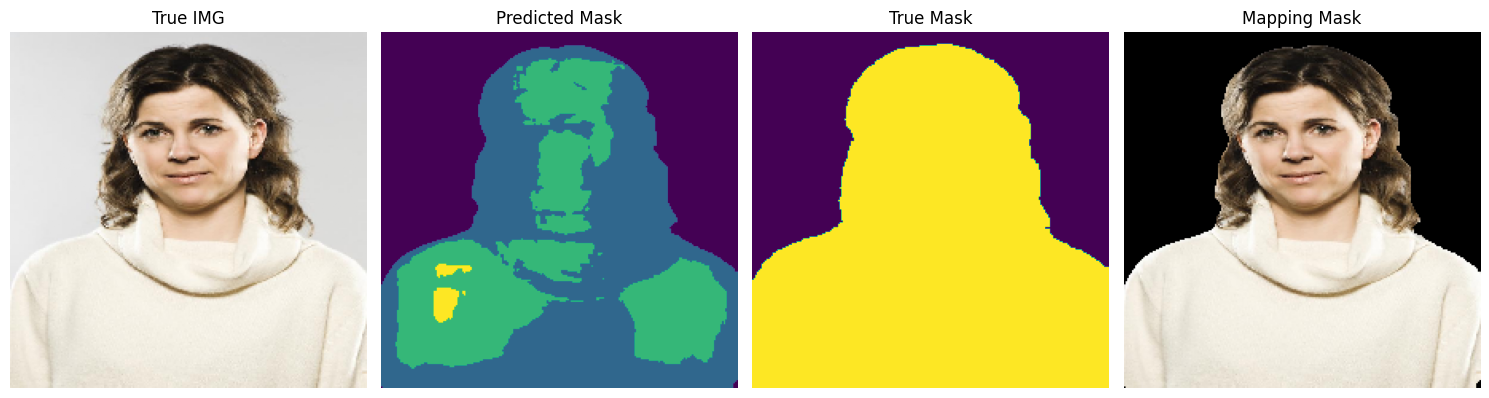

697/697 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - IoU: 0.7357 - accuracy: 0.9880 - loss: 0.0339 - val_IoU: 0.7444 - val_accuracy: 0.9880 - val_loss: 0.0428 - learning_rate: 7.2900e-07


In [29]:
segmodel.compile(optimizer="nadam", loss="binary_crossentropy", metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy']) #ids =1
epochs = 40
# 
hist = segmodel.fit(generator, epochs=epochs, batch_size=32, validation_data=valid, callbacks=[callback])

## Metrics

In [31]:
res_val = segmodel.evaluate(valid)

298/298 ━━━━━━━━━━━━━━━━━━━━ 137s 457ms/step - IoU: 0.8593 - accuracy: 0.9883 - loss: 0.0411


In [37]:
res_train = segmodel.evaluate(generator)

697/697 ━━━━━━━━━━━━━━━━━━━━ 252s 362ms/step - IoU: 0.7500 - accuracy: 0.9891 - loss: 0.0306


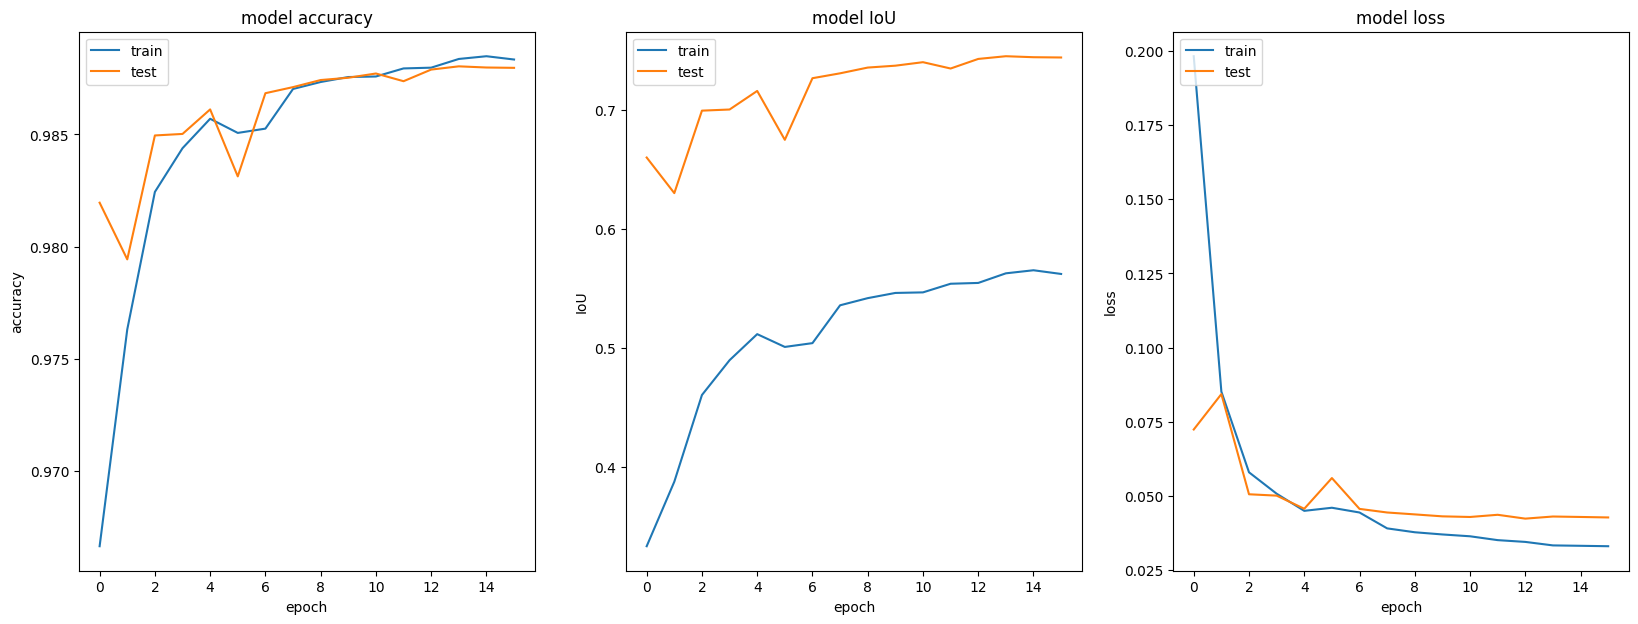

In [33]:
plt.figure(figsize=(20, 7))
plt.subplot(1,3,1)

# summarize history for accuracy
plt.subplot(1,3,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
plt.plot(hist.history['IoU'])
plt.plot(hist.history['val_IoU'])

plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## See some results

In [50]:
valid_mini = DataGenerator(X_test[0:32] ,y_test[0:32], batch_size=15, dim=(224,224,3))
mini_pred = segmodel.predict(valid_mini)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step


for i in range(len(mini_pred)):

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


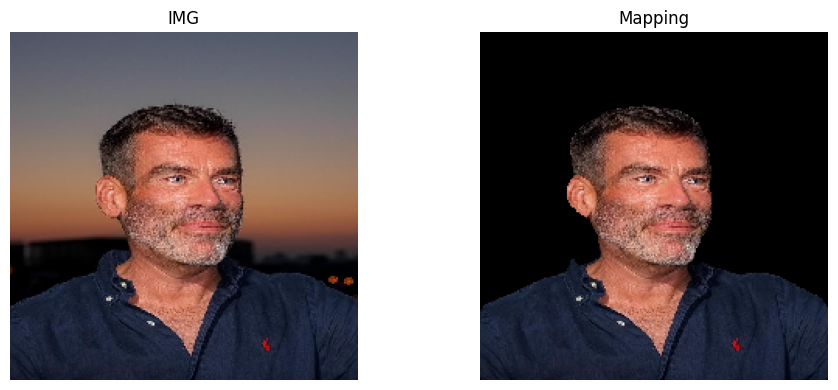

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


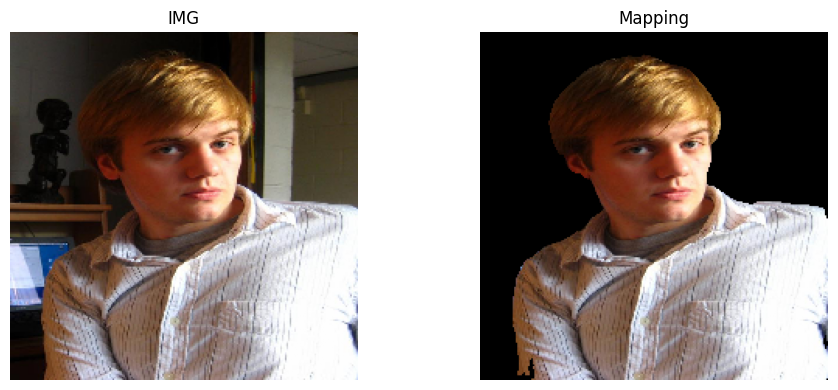

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


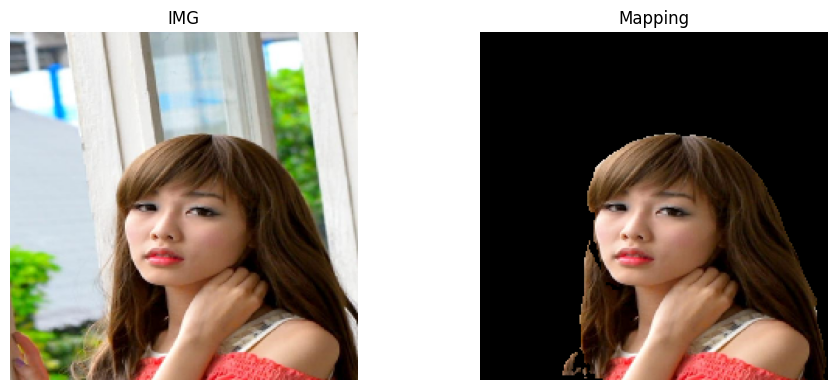

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


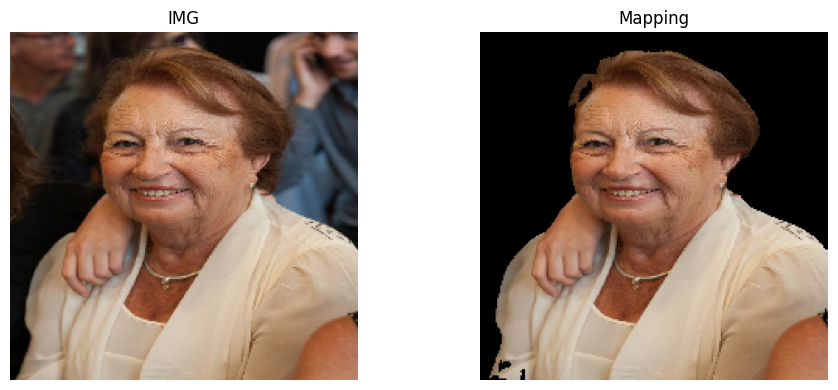

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


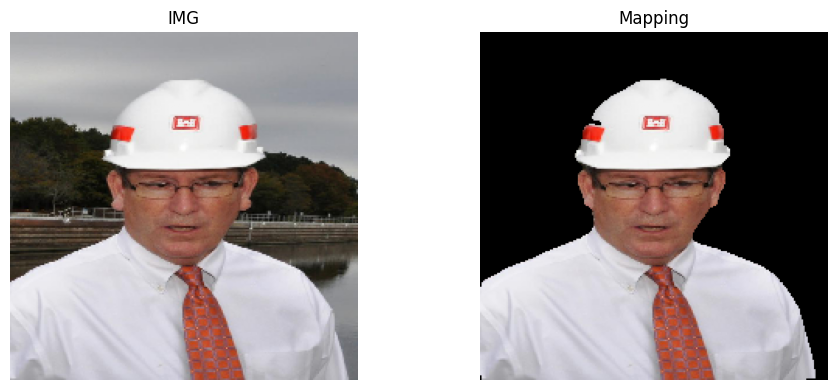

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


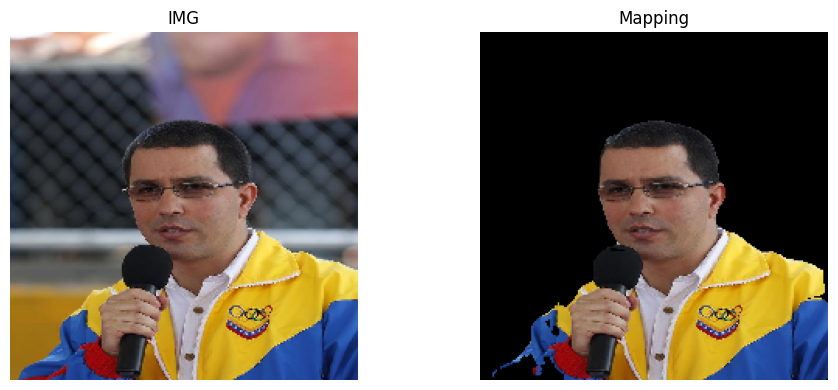

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


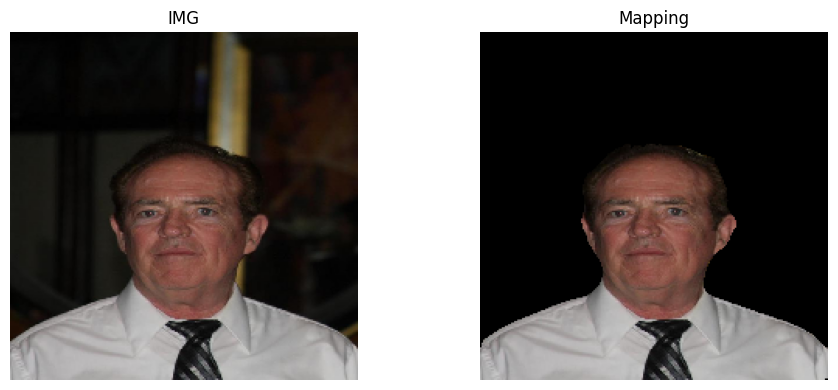

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


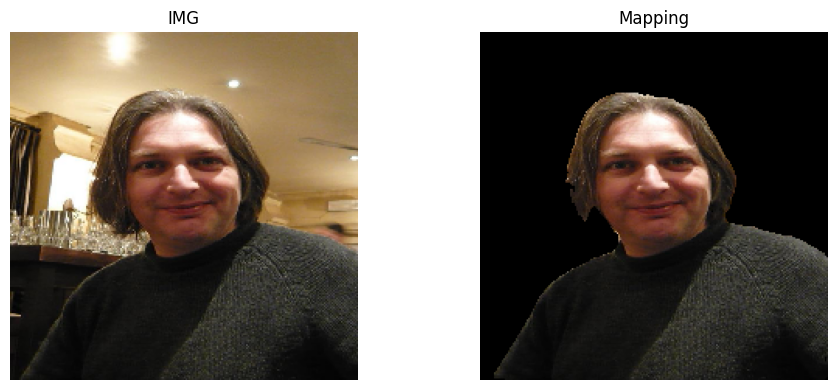

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


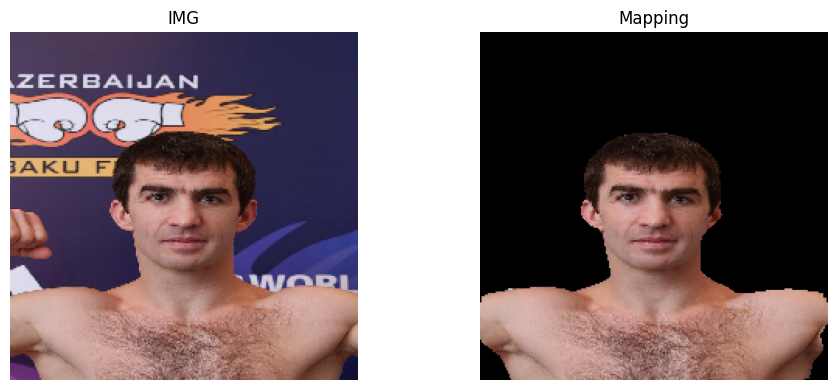

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


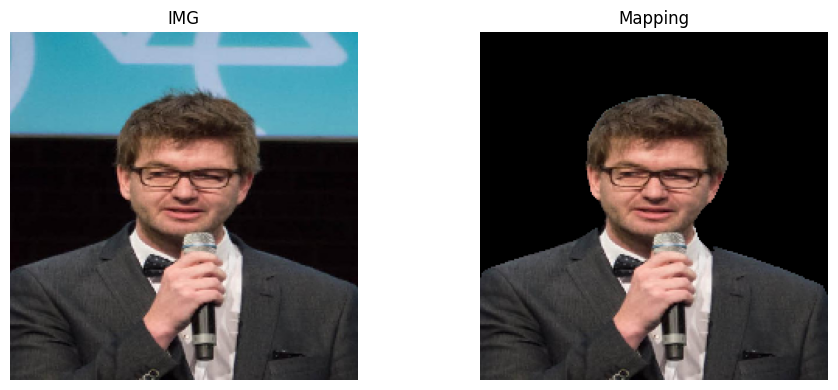

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


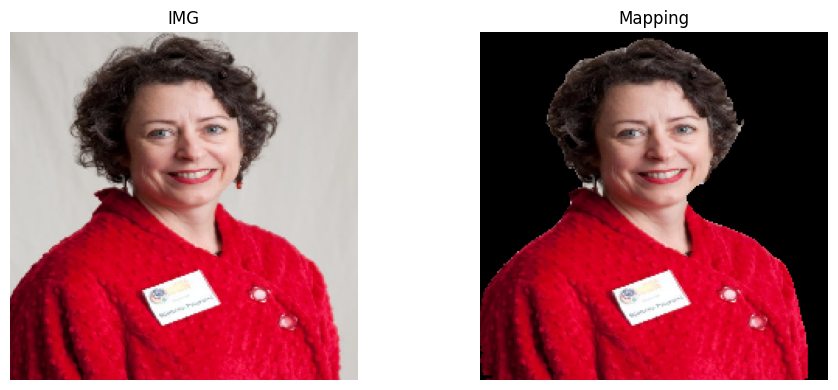

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


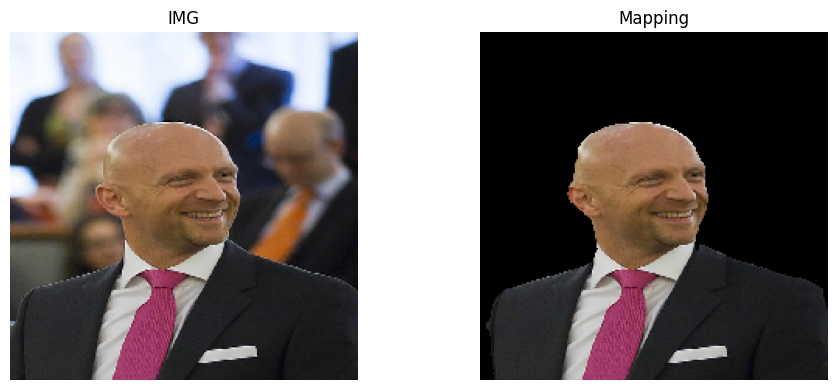

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


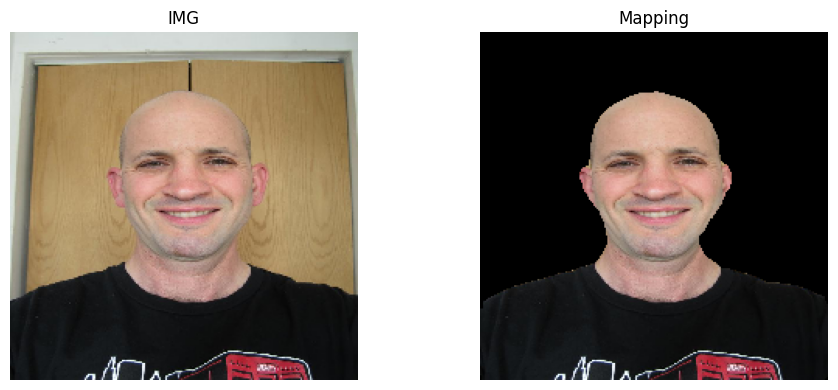

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


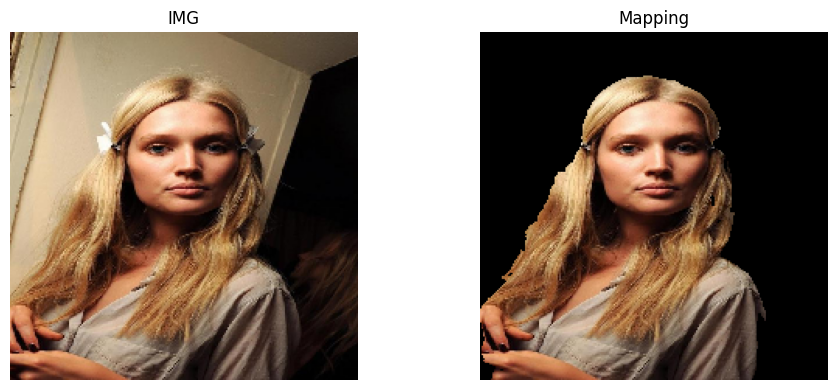

In [55]:
for i in range(14):
    plt.figure(figsize=(10,4))
    img = valid_mini[0][0][0:15] # так как метод предикт принимает только от 2х и более картинок тут первый batch
    pred_mask = segmodel.predict(img)[i] #[i-1]
        
    pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
    mapping = cv.bitwise_and(img[i],img[i],mask=pred_mask)#[0]  i-2 i-2

    plt.subplot(1,2,1)
    ShowImage(img[i],title="IMG")
    
    plt.subplot(1,2,2)
    ShowImage(mapping, title="Mapping")
    
    plt.tight_layout()
    plt.show()

## Save

In [46]:
segmodel.save('/kaggle/working/segmodel2112_17ep_IOU85.h5')

In [47]:
download_file('/kaggle/working/', 'hbgr_segmodel_2112_17ep_IOU85.h5')

/kaggle/working/hbgr_segmodel_2112_17ep_IOU85.h5.zip